# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
## import the packages
import pickle
import csv

import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import time

%matplotlib inline

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
## Load pickled data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_original, y_train_original = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# the coorinates are also loaded for tuture experiments
coords_train = train['coords']
coords_test = test['coords']

In [3]:
## let's also load the traffic sign id-name mapping file, getting a better clue of each image
id_name_mapping = {}
with open("signnames.csv", "r") as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader, None)   # omit the header
    for row in reader:
        id_name_mapping[int(row[0])] = row[1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

### 1.1, Data Integrity Check 

In [4]:
## a "shallow" verification of data integrity
assert(len(X_train_original) == len(y_train_original))
assert(len(X_test) == len(y_test))

In [5]:
## Replace each question mark with the appropriate value.
n_train = len(X_train_original)
n_test = len(X_test)
image_shape = X_train_original[0].shape
n_classes = len(np.unique(y_train_original))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
## let's see the types of the traffic sign data set
id_name_mapping

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

(2, 'Speed limit (50km/h)')


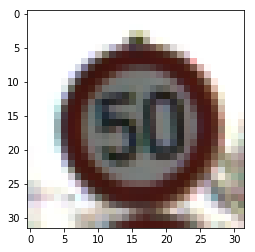

In [7]:
# randomly show an image
def show_rand_image_with_given_class(images, labels, label_id, is_gray=False):
    image_per_class = images[np.where(labels == label_id)]
    index = random.randint(0, len(image_per_class))
#     plt.figure(figsize=(1,1))
    if is_gray:
        squeezed_gray = np.squeeze(image_per_class)
        plt.imshow(squeezed_gray[index], cmap="gray")
    else:
        image = image_per_class[index]
        plt.imshow(image)
    print((label_id, id_name_mapping[label_id]))

show_rand_image_with_given_class(X_train_original, y_train_original, 2)

### 1.2, Sample number distribution

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [8]:
# the number of training and test samples per classes
class_numbers_train = np.array([len(y_train_original[y_train_original == i]) for i in range(n_classes)])
class_numbers_test = np.array([len(y_test[y_test == i]) for i in range(n_classes)])

<Container object of 43 artists>

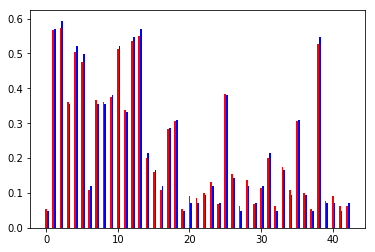

In [9]:
# let's plot the distribution, to compare the distribution of training and testing set, the propotion of each against
# the whole data set is calculated. 
# todos: 1) add legend, 2) graph wider, center aligned 3) show classes 
plt.bar(np.arange(n_classes), class_numbers_train/float(len(y_train_original))*10, color='r', width=0.25)
plt.bar(np.arange(n_classes)+0.25, class_numbers_test/float(len(y_test))*10, color='b', width=0.25)

In [ ]:
## todo, analyze quantitively. the mean, the median, the variance, etc. 

### 1.3, Findings and Thoughts

**Characteristics:** the above graph shows the following characteristics:
1. the number of samples contained in each class varies dramatically.
1. the number of each class follows nearly the same pattern in both traing and testing classes

**Thoughts** this dataset gives the following guess (and can be experimented):
- The model maybe preferenced to classes with more training examles, since the more data given to the model, the more "impression" the model gets of that class, which leads to higher classification accuracy of this class;


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### 2.0, Data preparation

In [10]:
def split_data(x, y, size=0.1):
    print("Training before split: %s" % len(x))

    # Get randomized datasets for training and validation
    X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=size, random_state=832289)

    assert(len(X_train) == len(y_train))
    assert(len(X_validation) == len(y_validation))

    print("Training after split: %s " % len(X_train))
    print("Validation after split: %s " % len(X_validation))
    return X_train, X_validation, y_train, y_validation

In [11]:
X_train, X_validation, y_train, y_validation = split_data(X_train_original, y_train_original, size=0.2)

Training before split: 39209
Training after split: 31367 
Validation after split: 7842 


In [12]:
# validate the splitted data
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
X_train.shape, X_validation.shape

((31367, 32, 32, 3), (7842, 32, 32, 3))

### 2.1, Training with LeNet-5 

In [13]:
rate = 0.001
EPOCHS = 10
BATCH_SIZE = 128

In [14]:
## def the network
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc2, fc3_W) + fc3_b

In [15]:
# define the tensors
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [16]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [18]:
t = time.time()

validation_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy.append(evaluate(X_validation, y_validation))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
        print()

    saver.save(sess, './checkpoints/lenet-original-epoch10')
    print("Model saved")

print()
print("Time Eclipsed: " + str(time.time() - t))

Training...

EPOCH 1 ...
Validation Accuracy = 0.704

EPOCH 2 ...
Validation Accuracy = 0.851

EPOCH 3 ...
Validation Accuracy = 0.897

EPOCH 4 ...
Validation Accuracy = 0.921

EPOCH 5 ...
Validation Accuracy = 0.930

EPOCH 6 ...
Validation Accuracy = 0.938

EPOCH 7 ...
Validation Accuracy = 0.943

EPOCH 8 ...
Validation Accuracy = 0.954

EPOCH 9 ...
Validation Accuracy = 0.955

EPOCH 10 ...
Validation Accuracy = 0.959

Model saved

Time Eclipsed: 25.5125732421875


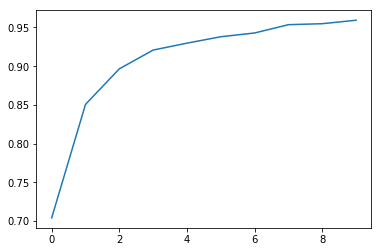

In [19]:
plt.plot(range(EPOCHS), validation_accuracy)

In [20]:
## run on the test set
t = time.time()
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-original-epoch10')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Time Eclipsed: " + str(time.time() - t))

Test Accuracy = 0.882
Time Eclipsed: 0.6035764217376709


**Analysis**
With same configurations, learning-rate, epochs, batch-size, etc.; when LeNet-5 is applied to MNIST, it gets a validation accuracy of 0.99 and test accuracy of 0.989, while when applied to the traffic data set, it gets a validation accuracy 0.957 and the test accuracy 0.878; 

**This gives the following consideration: **
- The difference of characteristics between the two data sets: 
    1. for MINIT, it's gray-scaled, and the image is "clean"(without too much noise); while the traffic data is colored with much noise; 
    2. as for the data volume, as can be seen in below graph, the MNIST data contains 55000 samples and ten classes, while the traffic data contains 31367 samples and 43 classes, the data volume is much smaller than the MNIST, which leads to that the trained model may not generalize well. 
    
** To overcome above issues, the following actions can be taken**
- gray-scale the image and run against LeNet-5
- generate more data for those with less volume classes
- run more epochs (maybe)


<Container object of 43 artists>

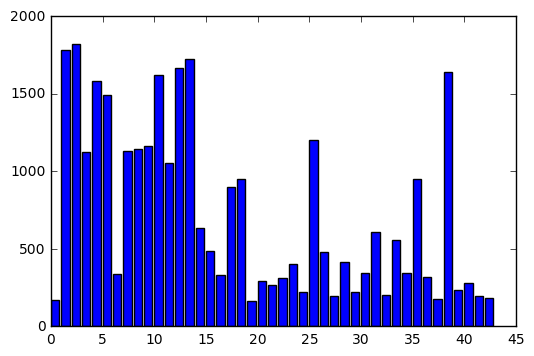

In [122]:
class_numbers_train = np.array([len(y_train[y_train == i]) for i in range(n_classes)])
plt.bar(range(n_classes), class_numbers_train)

---
### 2.2, Gray-scale the images and training with LeNet-5 

In [21]:
# gray-scale images
t = time.time()

with tf.Session() as sess:
    X_train_gray = sess.run(tf.image.rgb_to_grayscale(X_train))
    X_validation_gray = sess.run(tf.image.rgb_to_grayscale(X_validation))
    X_test_gray = sess.run(tf.image.rgb_to_grayscale(X_test))
    
print("Time Eclipsed: " + str(time.time() - t))

Time Eclipsed: 3.3337409496307373


In [124]:
# verify the shape
X_train_gray.shape

(31367, 32, 32, 1)

(2, 'Speed limit (50km/h)')


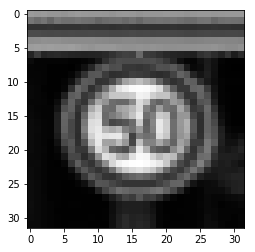

In [22]:
show_rand_image_with_given_class(X_train_gray, y_train, 2, is_gray=True)

In [23]:
# let's redefine the architecture
## def the network
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc2, fc3_W) + fc3_b


In [24]:
# define the tensors
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [25]:
t = time.time()

validation_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffled, y_train_shuffled = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy.append(evaluate(X_validation_gray, y_validation))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
        print()

    saver.save(sess, './checkpoints/lenet-gray-epoch10')
    print("Model saved")

print()
print("Time Eclipsed: " + str(time.time() - t))

Training...

EPOCH 1 ...
Validation Accuracy = 0.746

EPOCH 2 ...
Validation Accuracy = 0.865

EPOCH 3 ...
Validation Accuracy = 0.919

EPOCH 4 ...
Validation Accuracy = 0.938

EPOCH 5 ...
Validation Accuracy = 0.948

EPOCH 6 ...
Validation Accuracy = 0.949

EPOCH 7 ...
Validation Accuracy = 0.947

EPOCH 8 ...
Validation Accuracy = 0.958

EPOCH 9 ...
Validation Accuracy = 0.964

EPOCH 10 ...
Validation Accuracy = 0.966

Model saved

Time Eclipsed: 20.28195023536682


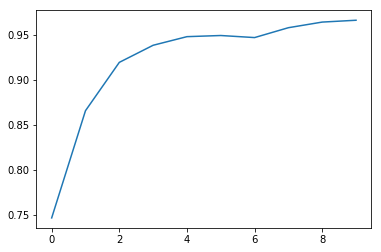

In [26]:
plt.plot(range(EPOCHS), validation_accuracy)

In [27]:
# run the medel on test set
## run on the test set
t = time.time()
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-gray-epoch10')
    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Time Eclipsed: " + str(time.time() - t))

Test Accuracy = 0.893
Time Eclipsed: 1.1851701736450195


**Analysis**

With the same hyper-parameters, when applied to LeNet5, the validation accuracy imcreased 97%, the test accuracy also increased a bit, about 4%, this a trival change; but the training time consumed decreased a lot, from 280 seconds to 190 seconds. To improve the performance, we need to increase the epochs, from 10 to 50. 


---
### 2.3, Gray-scale the images and training with LeNet-5 - with more epochs ( from 10 to 50 ) 

In [28]:
t = time.time()

EPOCHS = 50
validation_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffled, y_train_shuffled = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy.append(evaluate(X_validation_gray, y_validation))
        if (i % 5 == 0 and i != 0): 
            print("EPOCH {} ...".format(i))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
            print()

    saver.save(sess, './checkpoints/lenet-gray-epoch50')
    print("Model saved")

print()
print("Time Eclipsed: " + str(time.time() - t))

Training...

EPOCH 5 ...
Validation Accuracy = 0.945

EPOCH 10 ...
Validation Accuracy = 0.957

EPOCH 15 ...
Validation Accuracy = 0.968

EPOCH 20 ...
Validation Accuracy = 0.963

EPOCH 25 ...
Validation Accuracy = 0.978

EPOCH 30 ...
Validation Accuracy = 0.974

EPOCH 35 ...
Validation Accuracy = 0.977

EPOCH 40 ...
Validation Accuracy = 0.974

EPOCH 45 ...
Validation Accuracy = 0.979

Model saved

Time Eclipsed: 91.87591981887817


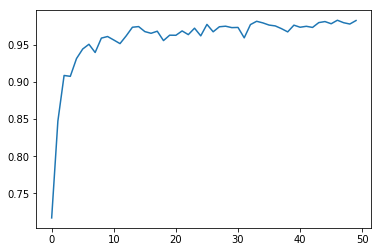

In [29]:
plt.plot(range(50), validation_accuracy)

In [30]:
# run the medel on test set
## run on the test set
t = time.time()
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-gray-epoch50')
    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Time Eclipsed: " + str(time.time() - t))

Test Accuracy = 0.917
Time Eclipsed: 1.035423755645752


**Analysis**

The validation accuracy shows that the modele stuck at around 0.975, one possible reason is the large learning rate, lets' lower the learning rate and run another 50 epochs

---
### 2.4, Gray-scale the images and training with LeNet-5 - with smaller learning rate

In [ ]:
t = time.time()

rate = rate / 10    # decrease the original rate 
validation_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_shuffled, y_train_shuffled = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy.append(evaluate(X_validation_gray, y_validation))
        if ((i % 5 == 0 and i != 0) or (i == EPOCHS - 1)): 
            print("EPOCH {} ...".format(i))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
            print()

    saver.save(sess, './checkpoints/lenet-gray-epoch50-small_rate')
    print("Model saved")

print()
print("Time Eclipsed: " + str(time.time() - t))

Training...

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 10 ...
Validation Accuracy = 0.933

EPOCH 15 ...
Validation Accuracy = 0.948

EPOCH 20 ...
Validation Accuracy = 0.964

EPOCH 25 ...
Validation Accuracy = 0.958



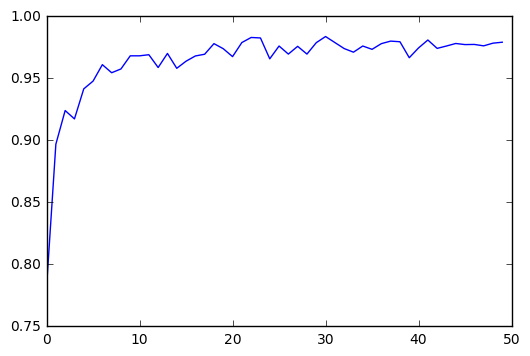

In [136]:
plt.plot(range(50), validation_accuracy)

In [137]:
# run the medel on test set
## run on the test set
t = time.time()
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-gray-epoch50-small_rate')
    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Time Eclipsed: " + str(time.time() - t))

Test Accuracy = 0.915
Time Eclipsed: 5.164635181427002


**Analysis**

Frustrated. Seems that adjusting the learning rate did no good to the final result, neither the validation accuracy nor the test accuracy improves. More training epochs does any better? Maybe. Anyway, let's try add a dropout strategy and try again. 


---
### 2.5, Gray-scale the images and training with LeNet-5 - with dropout

In [143]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))   # FIXME, image channel
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #SOLUTION: ADD A DROPOUT
    h_fc1_drop = tf.nn.dropout(fc2, keep_prob)  # the dropout connects to fc2

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(h_fc1_drop, fc3_W) + fc3_b   # change the fc2 to the dropoutted layer
    
    return logits

In [144]:
EPOCHS = 10
keep_prob = tf.placeholder(tf.float32)   # defined this 

In [145]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # during evaluation, using all the neurons
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [147]:
t = time.time()

validation_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})  # dropout one half, another paramter can be tunned.
            
        validation_accuracy.append(evaluate(X_validation_gray, y_validation))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
        print()
        
    saver.save(sess, './checkpoints/lenet-gray-dropout-epoch10')    
    print("Model saved")

print()
print("Time Eclipsed: " + str(time.time() - t))

Training...

EPOCH 1 ...
Validation Accuracy = 0.726

EPOCH 2 ...
Validation Accuracy = 0.870

EPOCH 3 ...
Validation Accuracy = 0.904

EPOCH 4 ...
Validation Accuracy = 0.921

EPOCH 5 ...
Validation Accuracy = 0.942

EPOCH 6 ...
Validation Accuracy = 0.928

EPOCH 7 ...
Validation Accuracy = 0.934

EPOCH 8 ...
Validation Accuracy = 0.954

EPOCH 9 ...
Validation Accuracy = 0.954

EPOCH 10 ...
Validation Accuracy = 0.959

Model saved

Time Eclipsed: 207.14199900627136


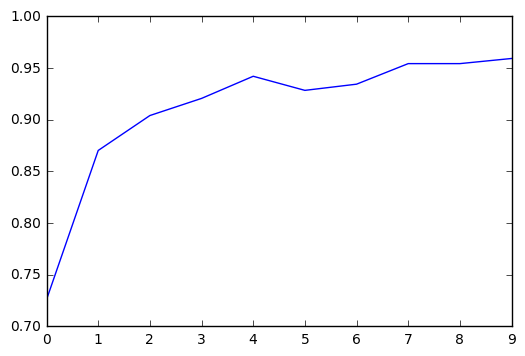

In [148]:
plt.plot(range(EPOCHS), validation_accuracy)

In [149]:
# run the medel on test set
## run on the test set
t = time.time()
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-gray-dropout-epoch10')
    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Time Eclipsed: " + str(time.time() - t))

Test Accuracy = 0.877
Time Eclipsed: 5.988423109054565


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [75]:

# loading the test images;
import os
import cv2

test_images = []
test_labels = []
for f in os.listdir("./test-images/"):
    if ".jpg" in f:
        img = cv2.imread("./test-images/" + f)
        assert(img.shape == (32,32,3))
        test_images.append(img)
        test_labels.append(f[:f.index("-")])
test_images = np.array(test_images)
test_images.shape

(11, 32, 32, 3)

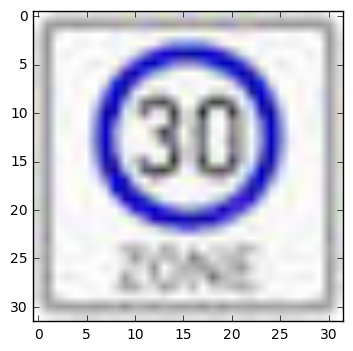

In [76]:
plt.imshow(test_images[2])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [77]:
## gray scale the test images
# gray-scale images
t = time.time()

with tf.Session() as sess:
    test_image_gray = sess.run(tf.image.rgb_to_grayscale(test_images))
    
print("Time Eclipsed: " + str(time.time() - t))

Time Eclipsed: 1.1076939105987549


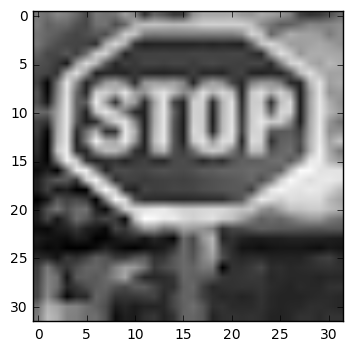

In [81]:
plt.imshow(np.squeeze(test_image_gray)[6], cmap="gray")

In [79]:
test_labels

['0', '0', '1', '1', '1', '1', '14', '2', '2', '2', '2']

In [140]:
t = time.time()
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-gray-epoch10')
    test_accuracy = evaluate(test_image_gray, test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Time Eclipsed: " + str(time.time() - t))

Test Accuracy = 0.182
Time Eclipsed: 2.625617027282715


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [92]:
test_image_gray.shape

(11, 32, 32, 1)

In [141]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/lenet-gray-epoch10')
    topk = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=3), feed_dict={x: test_image_gray})

In [142]:
topk

TopKV2(values=array([[  9.99777138e-01,   1.13090093e-04,   1.06541069e-04],
       [  6.45671725e-01,   3.54328364e-01,   4.62152361e-09],
       [  9.99999881e-01,   1.13723431e-07,   2.03229572e-10],
       [  9.99786079e-01,   1.37339681e-04,   4.65205339e-05],
       [  9.99996424e-01,   2.02221622e-06,   1.50574749e-06],
       [  9.99864101e-01,   1.06845837e-04,   2.16880708e-05],
       [  9.27194238e-01,   7.22199753e-02,   5.20852103e-04],
       [  4.42295194e-01,   3.77842784e-01,   8.73271301e-02],
       [  5.26087344e-01,   4.71692294e-01,   1.62167498e-03],
       [  1.00000000e+00,   5.78865027e-08,   3.79764380e-08],
       [  9.97366488e-01,   1.44611485e-03,   9.49590816e-04]], dtype=float32), indices=array([[11, 20, 21],
       [13, 34, 14],
       [14,  3, 34],
       [ 2,  3, 34],
       [ 5,  1,  2],
       [14, 25, 28],
       [16,  7, 21],
       [14, 13,  2],
       [31, 28, 14],
       [ 2,  1,  3],
       [ 2,  5,  3]], dtype=int32))

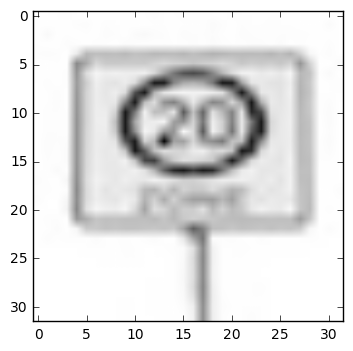

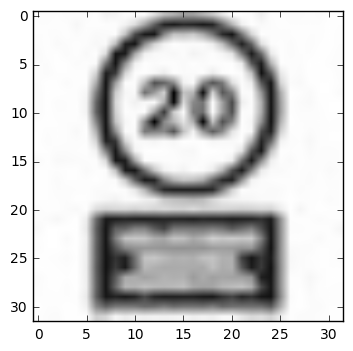

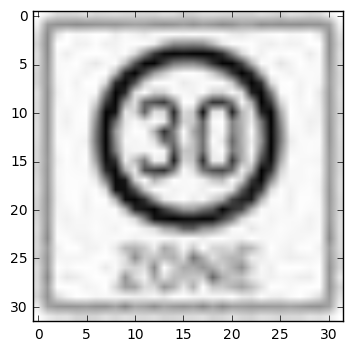

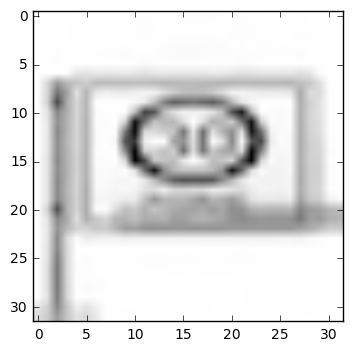

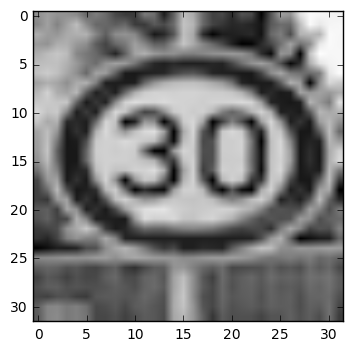

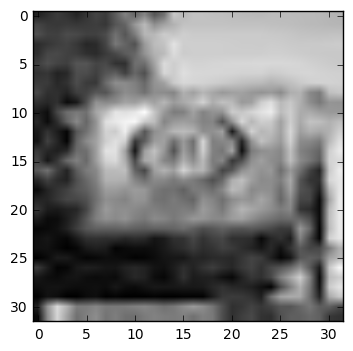

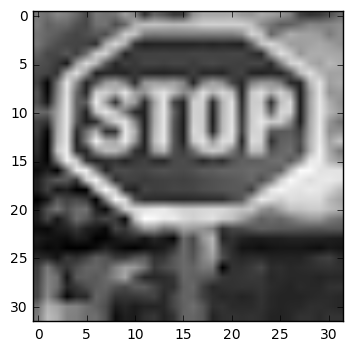

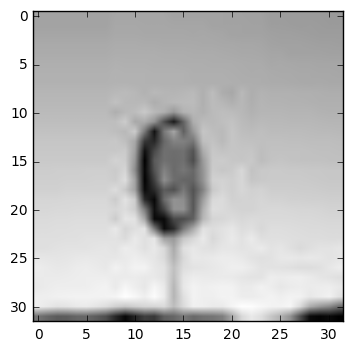

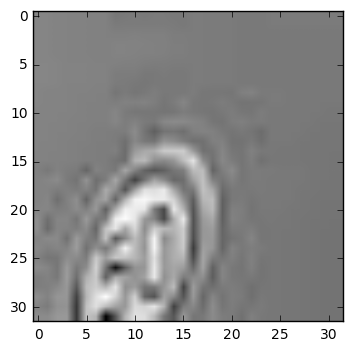

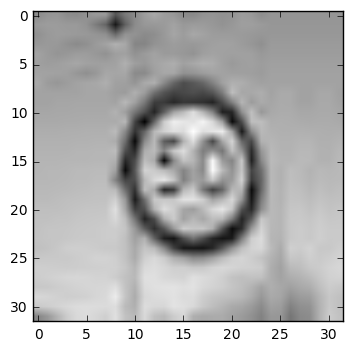

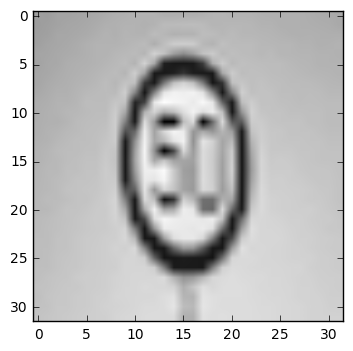

In [101]:
for i in range(len(test_image_gray)):
#     print(test_labels[i])
    plt.figure()
    plt.imshow(np.squeeze(test_image_gray[i]), cmap="gray")

**Answer:**

The model predicts the "speed limit 50" sign better than the others. Two possible reasons:
1.	the "speed limit 50" sign, class 2,  as can be seen from above graph (the sample number bar chart per class), contains much more samples than the class 0, more training data means better generalization;

1.	the “speed limit 30” sign, class 1, contains almost the same number of training sample as class 2, although the model does not predict correctly, in the top 3 rank, 2 images (50%) predicted correctly. 


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

**Todo**
The following will be the follow-ups on this task:
- Try the TensorBoard to analyze the models visually and for model comparing.
- Try generate more data
- Try using the pretrained models features (transfer learning, AlexNet, VGG, etc)
- Refactor the code to a more modularized manner.
